# Address Matching with Apache Spark

## Iniciar Spark

In [1]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder \
    .appName("Adress Matching") \
    .config("spark.executor.memory", "3g") \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()
    #.config("spark.local.dir", "/spark-tmp") \

24/04/16 10:11:39 WARN Utils: Your hostname, ubuntu resolves to a loopback address: 127.0.1.1; using 10.6.130.30 instead (on interface ens3)
24/04/16 10:11:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/16 10:11:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [22]:
conf = spark.sparkContext.getConf()
for (key, value) in conf.getAll():
  print(f"{key}: {value}")

spark.app.name: Adress Matching
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false
spark.executor.memory: 3g
spark.app.startTime: 1713173167645
spark.app.id: local-

## Leer fichero

El dataset continene exactamente 24 columnas las cuales, el ***, almacena información relevante el trabajo que realizan. En cambio, en este proyecto, se utilizarán las siguientes columnas pues contienen la información más relevante:
- **uuid_idt**: contiene un identificador alfanumérico único para cada dirección.
- **tvia**: contiene el tipo de vía, es decir, si es una calle, avenida, carretera, etc.
- **nvia**: contiene el nombre de la vía.
- **numer**: contiene el número de la vía.
- **codmun**: está compuesto por un código numérico que identifica a un municipio, es decir, el código postal.
- **nommun**: contiene el nombre del municipio.
- **direccion**: contiene la dirección completa."

In [23]:
# Leer el archivo CSV y cargarlo en un DataFrame
file =  "../data/raw_data/TFM_Direcciones.tab"
first_df = spark.read.option("delimiter", "\t").option("encoding", "windows-1252").csv(file, header=True, inferSchema=True)

# Seleccionar solo las columnas deseadas
selected_columns = [
  "uuid_idt",
  "tvia",
  "nvia",
  "numer",
  "codmun",
  "nommun",
  "direccion",
]
first_df = first_df.select(selected_columns)

# Mostrar el DataFrame
first_df.show()
first_df.schema
print(first_df.count())
size_df = first_df.count()

+--------------------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    0| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    2| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E..

1784217


In [24]:
from pyspark.sql.functions import upper

file =  "../data/raw_data/data-09022024.csv"
second_df = spark.read.option('header', True).csv(file)

selected_columns = [
  "uuid_idt",
  "codmun",
  "nommun",
  "direccion"
]

second_df = second_df.select(selected_columns)
second_df = second_df.select(upper('uuid_idt').alias('uuid_idt'), 'codmun', upper('nommun').alias('nommun'), 'direccion')
second_df.show()
first_df.schema
print(second_df.count())
size_df += second_df.count()

+--------------------+------+--------------------+--------------------+
|            uuid_idt|codmun|              nommun|           direccion|
+--------------------+------+--------------------+--------------------+
|C0CF3B94-0AD1-11E...| 35016|LAS PALMAS DE GRA...|IGUAZU 42 0 LAS P...|
|73B57C1B-3251-11E...| 35016|LAS PALMAS DE GRA...|PARQUE CENTRAL BL...|
|C70E3EC6-3EDA-11E...| 35016|LAS PALMAS DE GRA...|CONCEJAL GARCIA F...|
|687BA81E-3251-11E...| 35006|              ARUCAS|PEDRO MORALES DEN...|
|74921989-3251-11E...| 35019|SAN BARTOLOMÉ DE ...|ISLA LOBOS 19 0 S...|
|6C0D19FF-3251-11E...| 35016|LAS PALMAS DE GRA...|CALLE LEON Y CAST...|
|6360FDCD-3251-11E...| 35016|LAS PALMAS DE GRA...|VIGEN PILAR 45 4 ...|
|758B3855-3251-11E...| 35016|LAS PALMAS DE GRA...|CALLE PALMERA CAN...|
|5D36841A-7A6B-11E...| 35016|LAS PALMAS DE GRA...|RUPERTO CHAPI 0 L...|
|6C00DBF4-3251-11E...| 35021|       SANTA BRÍGIDA|MANUEL HERNANDEZ ...|
|733A49C5-3251-11E...| 35027|               TEROR| HERRERIA 36 0

In [25]:
print(size_df)

2414514


In [26]:
from pyspark.sql.functions import count

def uuid_frecuency(dataframe):
    values_under_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count < 9') \
        .groupBy('count') \
        .agg(count('*') \
        .alias('Frecuencia')) \
        .orderBy('count')
    values_under_10 = values_under_10.withColumnRenamed('count', 'Número de direcciones asociadas')

    values_over_10 = dataframe.groupBy(dataframe.uuid_idt).count() \
        .filter('count > 9')
    values_over_10 = spark.createDataFrame(
        [['10 o más', values_over_10.count()]],
        ['Número de direcciones asociadas', 'Frecuencia']
        )

    values = values_under_10.union(values_over_10)
    values.show()

uuid_frecuency(first_df)
uuid_frecuency(second_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    267275|
|                              2|    115343|
|                              3|     60757|
|                              4|     35631|
|                              5|     22207|
|                              6|     14810|
|                              7|     10142|
|                              8|      7411|
|                       10 o más|     25539|
+-------------------------------+----------+



+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    250632|
|                              2|     51645|
|                              3|     19692|
|                              4|      9055|
|                              5|      4702|
|                              6|      2876|
|                              7|      1772|
|                              8|      1161|
|                       10 o más|      4083|
+-------------------------------+----------+



## Unión de los dataframes

In [27]:
# Seleccionar los UUID únicos del primer DataFrame
unique_uuid_first_df = first_df.select("uuid_idt").distinct()

# Seleccionar los UUID únicos del segundo DataFrame
unique_uuid_second_df = second_df.select("uuid_idt").distinct()

# Encontrar los UUID comunes
uuid_comunes = unique_uuid_first_df.join(unique_uuid_second_df, "uuid_idt", "inner")
# Da el mismo resultado: uuid_primero.intersect(uuid_segundo)

# Juntar los UUID comunes con el primer DataFrame
adresses_df = first_df.unionByName(second_df.join(uuid_comunes, "uuid_idt", "inner"), allowMissingColumns=True)

# Mostrar el resultado
adresses_df.show()
print("Tamaño del dataframe ampliado: ", adresses_df.count())

# Si se quiere comprobar que la operación es correcta
print("Número de uuid_idt nuevos del segundo dataframe: ", unique_uuid_second_df.subtract(uuid_comunes).count())

+--------------------+------------+--------------------+-----+------+------+--------------------+
|            uuid_idt|        tvia|                nvia|numer|codmun|nommun|           direccion|
+--------------------+------------+--------------------+-----+------+------+--------------------+
|027C0FF8-B17B-11E...|       CALLE|        FUENTE SANTA|    5| 35001|Agaete|CALLE FUENTE SANT...|
|028F2302-B17B-11E...|       CALLE|       CRUZ CHIQUITA|    2| 35001|Agaete|CALLE CRUZ CHIQUI...|
|02918516-B17B-11E...|URBANIZACION|RESIDENCIAL PALMERAL|    9| 35001|Agaete|URBANIZACION RESI...|
|03A306C0-7525-11E...|       CALLE|SEÑORITA MARIA MA...|    2| 35001|Agaete|CALLE SEÑORITA MA...|
|03A306C0-7525-11E...|       CALLE|SRTA M MANRIQUE LARA|    2| 35001|Agaete|CALLE SRTA M MANR...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    0| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E...|       CALLE| MARIA MANRIQUE LARA|    2| 35001|Agaete|CALLE MARIA MANRI...|
|03A306C0-7525-11E..

Tamaño del dataframe ampliado:  2234214


Número de uuid_idt nuevos del segundo dataframe:  148073


In [28]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    211768|
|                              2|    119917|
|                              3|     70050|
|                              4|     44000|
|                              5|     28925|
|                              6|     19650|
|                              7|     14050|
|                              8|     10331|
|                       10 o más|     38060|
+-------------------------------+----------+



## Partición del dataset

In [29]:
adresses_df = adresses_df.repartition(32)

## Limpieza del dataset

Tras visualizar el dataset, se observa que hay columnas que tienen valores desconocidos, representados con '_U', y camos vacíos.

In [30]:
print(f"Initial dataset size: {adresses_df.count()}")

Initial dataset size: 2234214


### Valores nulos

In [31]:
from pyspark.sql.functions import isnan, when, count, col

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+------+------+------+------+------+---------+
|uuid_idt|  tvia|  nvia| numer|codmun|nommun|direccion|
+--------+------+------+------+------+------+---------+
|       0|580357|460216|449997|     0|     0|        0|
+--------+------+------+------+------+------+---------+



In [32]:
adresses_df = adresses_df.na.fill('_U')

adresses_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in adresses_df.columns]).show()

+--------+----+----+------+------+------+---------+
|uuid_idt|tvia|nvia| numer|codmun|nommun|direccion|
+--------+----+----+------+------+------+---------+
|       0|   0|   0|449997|     0|     0|        0|
+--------+----+----+------+------+------+---------+



### Extracción del prefijo para eleminar valores '_U'

Tras analizar el dataset, se observa que para una dirección, el tipo de vía (tvia) puede aparecer vacío, en cambio, en la columna 'direccion' aparece este valor. Por lo que se procederá a extraer el prefijo de la columna 'direccion' para rellenar los valores vacíos de la columna 'tvia' evitando así la perdida de información.

In [33]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


In [34]:
tvia_types = adresses_df.select("tvia").distinct().collect()
tvia_types = {t.tvia for t in tvia_types if t.tvia != "_U" and not t.tvia.isnumeric()}
print(tvia_types)

{'CRTA', 'RAMBL', 'EDIFICIO', 'PLACETA', 'CAMNO', 'ESCALERA', 'ROTONDA', 'CALLEJUELA', 'PRJE', 'PATIO', 'C', 'PUENTE', 'CALE', 'CONJUNTO', 'MUNICIPIO', 'LADERA', 'CRA', 'VALLE', 'VIA PEATONAL', 'TORRENTE', 'SOLAR', 'PLAZUELA', 'BARRIADA', 'AGRUP', 'ACCESO', 'BAJADA', 'BLOQUES', 'RINCONADA', 'RIBERA', 'DC', 'ESCALA', 'POBLADO', 'PARQ', 'CHALET', 'CARRERA', 'VIA', 'COMPLEJO', 'CALLE', 'PLAZOLETA', 'PAGO', 'OTROS', 'TORRE', 'LUGAR', 'RONDA', 'RAMAL', 'SB', 'ESCALINATA', 'URBANIZACION', 'RAMBLA', 'TRAV', 'BCO', 'ACERA', 'PASEO ALTO', 'RINCON', 'MONTAÑA', 'FINCA', 'GRUPO', 'BRNCO', 'VILLAS', 'PROLONGACION', 'ENTRADA', 'ALAMEDA', 'PISTA', 'APARTAMENTOS', 'CASERIO', 'MERCADO', 'AMPLIACION', 'CG', 'AVENI', 'CSRIO', 'CC', 'CENTRO COMERCIAL', 'LU', 'SIN DATOS DOMICILIAR', 'SUBIDA', 'SENDERO', 'CORRAL', 'ALDEA', 'ZONA', 'PASO', 'CUESTA', 'POLIGONO', 'EXTRARRADIO', 'ESTRADA', 'POLIG', 'ANGOSTA', 'PASEO BAJO', 'PARTICULAR', 'PASILLO', 'LOMA', 'AVENIDA', 'BARRANCO', 'TRANSVERSAL', 'MONTE', 'PLAZA', 

In [35]:
from pyspark.sql.functions import regexp_extract, when

condition = (adresses_df.tvia == '_U') & (regexp_extract('direccion', r'^(\\S+)', 1).isin(tvia_types))
adresses_df = adresses_df.withColumn("tvia", when(condition, regexp_extract('direccion', r'^(\\S+)', 1)).otherwise(adresses_df.tvia))

In [36]:
print(f"Unknown tvia before prefix extraction: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before prefix extraction: 580357


Se puede observar que los tipos de vías que siguen siendo desconocidos es debido a que desde la columna de dirección no se ha podido extraer un prefijo que aparezca en la lista de los tipos de vías que tenemos en el dataset.

### Limpieza de entradas con valor '_U'

Tras realizar la limpieza del dataset y extraer el tipo de via de la columna 'direccion', se procederá a eliminar las entradas restantes que contengan valores '_U' en las columnas 'tvia' pues no aportan información relevante.

In [37]:
print(f"Unknown tvia before duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia before duplicated null cleaning: 580357


In [38]:
adresses_df = adresses_df.filter(adresses_df.tvia != '_U')

In [39]:
print(f"Unknown tvia after duplicated null cleaning: {adresses_df.filter(adresses_df.tvia == '_U').count()}")

Unknown tvia after duplicated null cleaning: 0


In [40]:
print(f"Tamaño final del dataframe: {adresses_df.count()}")

Tamaño final del dataframe: 1653857


## Aumento de datos

### Frecuencia de uuid_idt antes

In [19]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    278002|
|                              2|    109890|
|                              3|     57031|
|                              4|     32912|
|                              5|     20151|
|                              6|     13280|
|                              7|      9074|
|                              8|      6577|
|                       10 o más|     22563|
+-------------------------------+----------+



### Aumento de datos

- Cambiar el orden de las palabras
- Añadir errores ortográficos
- Añadir sinónimos

In [44]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

# Define la función UDF
def switch_letters(direcction):
    """Intercambia letras adyacentes en una palabra"""
    words = direcction.split()
    word_candidates = [word for word in words if word.isalpha() and len(word) >= 2]
    if not word_candidates:
        return direcction
    word = random.choice(word_candidates)
    pos = random.randint(0, len(word) - 2)
    return " ".join(
        w if w != word else w[:pos] + w[pos + 1] + w[pos] + w[pos + 2:]
        for w in words
    )

def update_direction_via(tvia, direction):
    """Actualiza el tipo de vía de la dirección"""
    old_tvia = direction.split(" ")[0]
    if tvia.upper() in tvia_types:   
        direction = direction.replace(old_tvia, tvia)
    return direction

def select_via_type(tvia):
    """Selecciona tipos de vía alternativos sin duplicados"""
    return random.choice([t for t in tvia_types if t.title() != tvia and t != tvia.lower()])


unique_filtered_uuids = adresses_df.groupBy("uuid_idt").count().filter("count < 10").select("uuid_idt").sample(0.5)

to_extend = adresses_df.join(unique_filtered_uuids, "uuid_idt")

# Registra la función UDF con Spark
spark.udf.register("switch_letters", switch_letters, StringType())
spark.udf.register("select_via_type", select_via_type, StringType())
spark.udf.register("update_direction_via", update_direction_via, StringType())

# Aplica la función UDF a la columna "direccion" usando withColumn
extended_ds = (to_extend
    .withColumn("tvia", udf(select_via_type, StringType())("tvia"))
    .withColumn("direccion", udf(update_direction_via, StringType())("tvia", "direccion"))
    .withColumn("direccion", udf(switch_letters, StringType())("direccion"))
)

extended_ds.show(truncate=False)
print(extended_ds.count(), adresses_df.count())
adresses_df = adresses_df.union(extended_ds)
print(adresses_df.count())
uuid_frecuency(adresses_df)

24/04/15 10:30:26 WARN SimpleFunctionRegistry: The function switch_letters replaced a previously registered function.
24/04/15 10:30:26 WARN SimpleFunctionRegistry: The function select_via_type replaced a previously registered function.
24/04/15 10:30:26 WARN SimpleFunctionRegistry: The function update_direction_via replaced a previously registered function.


+------------------------------------+-------------------+-------------------------------+-----+------+--------------------------+---------------------------------------------------------------------+
|uuid_idt                            |tvia               |nvia                           |numer|codmun|nommun                    |direccion                                                            |
+------------------------------------+-------------------+-------------------------------+-----+------+--------------------------+---------------------------------------------------------------------+
|00AB4743-6F76-427F-919F-348FA15BF830|CARRETERA          |CAMINO TRES                    |83   |38008 |Breña Alta                |CARRETERA CAMINO TRES 83 BREAÑ ALTA                                  |
|0103D93A-4455-4962-A565-8ACCE76883B6|CALLEJON           |SAN ISIDRO MAJADILLA           |12   |35027 |Teror                     |CALLEJON SNA ISIDRO MAJADILLA 12 TEROR                            

569504 1653857


2223361


+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    139046|
|                              2|    193867|
|                              3|     28602|
|                              4|     71501|
|                              5|     10034|
|                              6|     35103|
|                              7|      4576|
|                              8|     19667|
|                       10 o más|     49488|
+-------------------------------+----------+



### Frecuencia de uuid_idt después

In [45]:
uuid_frecuency(adresses_df)

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    139046|
|                              2|    193867|
|                              3|     28602|
|                              4|     71501|
|                              5|     10034|
|                              6|     35103|
|                              7|      4576|
|                              8|     19667|
|                       10 o más|     49488|
+-------------------------------+----------+



## División de dataset

In [46]:
# Obtener los uuids únicos y convertirlos a una lista de Python
unique_uuids = [row[0] for row in adresses_df.select("uuid_idt").distinct().collect()]

In [47]:
# Crear DataFrame del 80%
train_df = adresses_df.sampleBy("uuid_idt", fractions={uuid: 0.8 for uuid in unique_uuids}, seed=42)

# Crear DataFrame del 20% restando el DataFrame del 80% al original
test_df = adresses_df.subtract(train_df)

In [48]:
print(adresses_df.count())
print(train_df.count())
print(test_df.count())

2223361


24/04/15 10:38:08 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


1777280


24/04/15 10:38:44 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:39:25 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:39:36 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


900050


In [49]:
print(adresses_df.select("uuid_idt").distinct().count())
print(train_df.select("uuid_idt").distinct().count())
print(test_df.select("uuid_idt").distinct().count())

554325


24/04/15 10:40:02 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:40:17 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


518334


24/04/15 10:40:36 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:41:16 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:41:26 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


378159


In [50]:
uuid_frecuency(train_df)
uuid_frecuency(test_df)

24/04/15 10:41:40 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:41:57 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:10 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:25 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:34 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:36 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:41 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:44 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:42:47 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB


+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    178113|
|                              2|    147224|
|                              3|     49279|
|                              4|     43088|
|                              5|     21783|
|                              6|     18646|
|                              7|     11979|
|                              8|     10441|
|                       10 o más|     29970|
+-------------------------------+----------+



24/04/15 10:43:07 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:43:46 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:43:58 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:44:05 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:44:24 WARN DAGScheduler: Broadcasting large task binary with size 28.1 MiB
24/04/15 10:45:02 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:14 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:22 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:29 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:33 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:37 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB
24/04/15 10:45:39 WARN DAGScheduler: Broadc

+-------------------------------+----------+
|Número de direcciones asociadas|Frecuencia|
+-------------------------------+----------+
|                              1|    187279|
|                              2|     81428|
|                              3|     39483|
|                              4|     23564|
|                              5|     14993|
|                              6|      9876|
|                              7|      6953|
|                              8|      4808|
|                       10 o más|      6108|
+-------------------------------+----------+



In [ ]:
# Escribir el resultado en un archivo parquet
try:
  train_df.write.format('parquet').save("../data/proccesed_data/train_dataframe2.parquet")
except:
  print('No se pudo guardar el dataset de entrenamiento.')

24/03/14 17:00:55 WARN DAGScheduler: Broadcasting large task binary with size 28.3 MiB


In [ ]:
# Escribir el resultado en un archivo parquet
try:
  test_df.write.format('parquet').save("../data/proccesed_data/test_dataframe2.parquet")
except:
  print('No se ha podido guardar el dataset de testeo.')

No se ha podido guardar el dataset de testeo.


## Representación con embeddings

#### Lectura del dataframe de entrenamiento

In [2]:
try:
  train_df = spark.read.format('parquet').load('../data/proccesed_data/train_dataframe2.parquet').repartition(32)
except:
  print('No se ha podido leer el dataset de entrenamiento.')

### Representación mediante _Word2Vec_

In [52]:
from pyspark.ml.feature import Word2Vec, Tokenizer

# Tokenizar el texto
tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
data_tokenized = tokenizer.transform(train_df)

# Entrenar el modelo Word2Vec
word2Vec = Word2Vec(vectorSize=300, minCount=0, inputCol="words", outputCol="embedding")
model_word2vec = word2Vec.fit(data_tokenized)

# Transformar los datos
word2vec_result = model_word2vec.transform(data_tokenized)
# ~9min

In [ ]:
word2vec_result.show(truncate=False)

24/03/14 12:32:13 WARN DAGScheduler: Broadcasting large task binary with size 28.2 MiB


+------------------------------------+--------+----------------------------+-----+------+----------+-------------------------------------------+----------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Escritura del modelo y del dataset con el embedding

In [ ]:
try:
  model_word2vec.write().overwrite().save("../models/word2vec_model")
except:
  print('No se ha podido guardar el modelo word2vec.')

24/03/19 16:08:22 WARN TaskSetManager: Stage 181 contains a task of very large size (18046 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
try:
  word2vec_result.write.format('parquet').save("../data/proccesed_data/word2vec_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding word2vec.')

### Representación con GPT

In [41]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI

def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings"
gpt3_result = train_df.withColumn("embedding", embedding_udf("direccion"))

In [43]:
gpt3_result.show(truncate=False)

24/04/16 12:11:08 ERROR Executor: Exception in task 0.0 in stage 179.0 (TID 987)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/tmp/ipykernel_44518/3890246167.py", line 11, in <lambda>
  File "/tmp/ipykernel_44518/3890246167.py", line 8, in get_embedding
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/resources/embeddings.py", line 113, in create
    return self._post(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 1208, in post
    return cast(ResponseT, self.request(cast_to, opts, stream=stream, stream_cls=stream_cls))
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 897, in request
    return self._request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 973, in _request
    return sel

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/tmp/ipykernel_44518/3890246167.py", line 11, in <lambda>
  File "/tmp/ipykernel_44518/3890246167.py", line 8, in get_embedding
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/resources/embeddings.py", line 113, in create
    return self._post(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 1208, in post
    return cast(ResponseT, self.request(cast_to, opts, stream=stream, stream_cls=stream_cls))
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 897, in request
    return self._request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 973, in _request
    return self._retry_request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 1021, in _retry_request
    return self._request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 973, in _request
    return self._retry_request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 1021, in _retry_request
    return self._request(
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/openai/_base_client.py", line 988, in _request
    raise self._make_status_error_from_response(err.response) from None
openai.RateLimitError: Error code: 429 - {'error': {'message': 'Your account is not active, please check your billing details on our website.', 'type': 'billing_not_active', 'param': None, 'code': 'billing_not_active'}}


#### Escritura del dataset con el embedding

In [ ]:
try:
  gpt3_result.write.format('parquet').save("../data/proccesed_data/gpt3_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de gpt3.')

No se ha podido guardar el dataset con embedding de gpt3.


### Representación con MiniLM

In [3]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf

model = SentenceTransformer("all-MiniLM-L6-v2")

def minilm_embedding(direccion):
    """ Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark """
    # Sentences are encoded by calling model.encode()
    embedding = model.encode(direccion)
    return embedding.tolist()  # Convertir el embedding a una lista de Python para evitar la serelización

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_udf(direccion):
    return minilm_embedding(direccion)

minilm_result = train_df.withColumn("embedding", minilm_embedding_udf("direccion"))

/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
minilm_result.show(truncate=False)

#### Escritura del modelo y del dataset con el embedding

In [ ]:
# ~200min
try:
  minilm_result.write.format('parquet').save("../data/proccesed_data/minilm_result.parquet")
except:
  print('No se ha podido guardar el dataset con embedding de minilm.')

### Representación gráfica

In [62]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
tokenized_sentences = tokenizer.transform(adresses_df).select("words").collect()
tokenized_sentences = [sentence.words for sentence in tokenized_sentences]
print(tokenized_sentences[:10])

[['calle', 'sotavento', '118', 'antigua'], ['calle', 'fermina', '55', 'arrecife'], ['calle', 'b', 'villa', 'pirula', '26', 'la', 'oliva'], ['calle', 'bilbao', '55', 'arrecife'], ['calle', 'guanarteme', 'cruce', 'arinaga', '133', 'agüimes'], ['calle', 'dr', 'barnard', '3', 'ingenio'], ['calle', 'palmeral', '1', 'haria'], ['calle', 'verol', 'caleta', 'fuste', '25', 'antigua'], ['calle', 'diama', 'argana', 'alta', '41', 'arrecife'], ['calle', 'camino', 'volcan', 'macher', '7', 'arrecife']]


In [63]:
word_counter = dict()
for sentence in tokenized_sentences:
    for word in sentence:
        if word not in word_counter:
            word_counter[word] = 1
        else:
            word_counter[word] += 1

word_counter = spark.createDataFrame(
    word_counter.items(),
    ["word", "count"]
).orderBy("count", ascending = False)

# Creo la columa frecuencia
word_counter = word_counter.withColumn(
    "frequency",
    word_counter["count"] / word_counter.count()
)
word_counter.show()

+---------+-------+------------------+
|     word|  count|         frequency|
+---------+-------+------------------+
|    calle|1163401| 9.279369890329013|
|       de| 987371| 7.875341974077767|
|      san| 472800| 3.771086739780658|
|       la| 398688| 3.179964107676969|
|    santa| 284912| 2.272478564307079|
|     gran| 238890|1.9054037886340978|
|  canaria| 227676|1.8159601196410768|
|     cruz| 223350|1.7814556331006979|
|   laguna| 211761|1.6890209371884346|
|cristobal| 210151|1.6761794616151546|
|   palmas| 197517|1.5754097706879362|
|      las| 195800|1.5617148554336988|
| tenerife| 159233|1.2700538384845463|
|        0| 145890| 1.163629112662014|
|  avenida| 124823|0.9955972083748754|
|   camino| 109253|0.8714097706879362|
|        1| 107738|0.8593260219341974|
| tirajana| 105530| 0.841714855433699|
|      los| 102542|0.8178823529411765|
|carretera| 101610|0.8104486540378864|
+---------+-------+------------------+
only showing top 20 rows



<Axes: xlabel='word'>

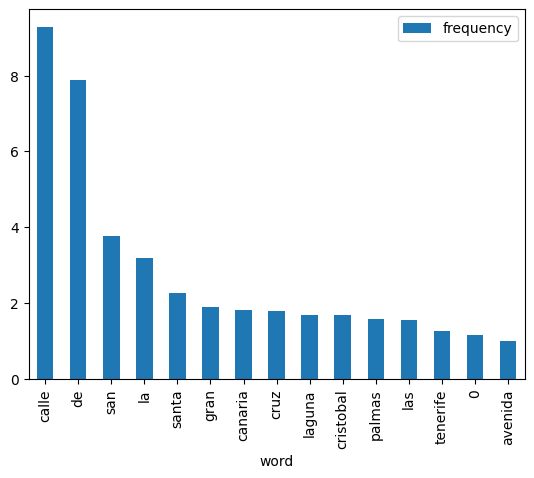

In [67]:
import matplotlib.pyplot
# Imprimir las 20 palabras más frecuentes
word_counter.toPandas().head(15).plot.bar(x = "word", y = "frequency")

## Distancia entre direcciones

In [4]:
try:
  test_dataframe = spark.read.format('parquet').load('../data/proccesed_data/test_dataframe2.parquet').repartition(32)
except:
  print('No se ha podido leer el dataset de testeo.')

# *TODO*:
- Hacer todo por lotes. Aplicar el crossjoin por lotes y realizar las evaluaciones
- Extraer muestras para realizar las evaluaciones
- Buscar la manera de extraer la informacion para usar Chromadb, es posible aplicar la realizacion por lotes
- Dos opciones: tener dos dataframes en chroma o tener uno pero añadir metadato para diferenciarlos.

## 10/04
- Limitar los datos a un municipio o isla para verlos resultados y comprobar que todo funciona (añadir como metadato el munipio y codigo postal)
- Comprobar cuanto destacan las distancias

### Distancia del coseno

In [3]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def accertion_ratio(dataframe):
  return dataframe.filter("evaluation == true").count() / dataframe.count()

def calculate_cosine_similarity(df1, df2):
  """ Realiza el cross join de dos dataframes """
  
  return df2.select("uuid_idt", "direccion", "embedding") \
    .withColumnRenamed("uuid_idt", "uuid_idt2") \
    .withColumnRenamed("direccion", "direccion2") \
    .withColumnRenamed("embedding", "embedding2") \
    .crossJoin(df1) \
    .repartition(32) \
    .withColumn("cosine_similarity", cosine_similarity("embedding", "embedding2"))
  
def filter_3_best(dataset):
  # Definimos la ventana de partición por uuid_idt y ordenamos por la columna cosine_similarity en orden descendente
  windowSpec = Window.partitionBy("uuid_idt").orderBy(col("cosine_similarity").desc())

  cosine_similarity_df = dataset.withColumn("rank", row_number().over(windowSpec))

  top3_cosine_similarity_df = cosine_similarity_df.filter(col("rank") == 1)
  # top3_cosine_similarity_df.select("uuid_idt2", "direccion2", "uuid_idt", "direccion", "rank").show()
  return top3_cosine_similarity_df.drop("rank")

@udf(returnType=FloatType())
def cosine_similarity(embedding_dir1, dirembedding_dir2):
    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))

# Registrar la función UDF en Spark
spark.udf.register("cosine_similarity", cosine_similarity)

""" from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from functools import reduce

# Función para calcular la similitud del coseno
@udf(returnType=FloatType())
def cosine_similarity(embedding_dir1, dirembedding_dir2):
    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))

# Registrar la función UDF en Spark
spark.udf.register("cosine_similarity", cosine_similarity)

# Función para calcular la similitud del coseno en lotes
def calculate_cosine_similarity_in_batches(df1, df2, batch_size=1000):
    
    df2 = df2.select("uuid_idt", "direccion", "embedding") \
      .withColumnRenamed("uuid_idt", "uuid_idt2") \
      .withColumnRenamed("direccion", "direccion2") \
      .withColumnRenamed("embedding", "embedding2") \
    # Obtener el número total de filas en df2
    total_rows = df2.count()
    # Calcular el número total de lotes
    num_batches = total_rows // batch_size + (1 if total_rows % batch_size > 0 else 0)
    
    # Lista para almacenar los resultados
    results = []
    
    # Procesar en lotes
    for i in range(num_batches):
        # Obtener el rango de filas para el lote actual
        start_row = i * batch_size
        end_row = min((i + 1) * batch_size, total_rows)
        
        # Obtener el lote del DataFrame df2
        batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row))
        
        # Realizar el join entre los lotes
        joined_df = batch_df2.crossJoin(df1)
        
        # Calcular la similitud del coseno en el lote actual
        batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding"))
        
        # Agregar los resultados del lote a la lista
        results.append(batch_results)
    
    # Combinar los resultados de los lotes en un solo DataFrame
    return reduce(lambda df1, df2: df1.union(df2), results)

# Función para filtrar los 3 mejores resultados
def filter_3_best(dataset):
    # Definir la ventana de partición por uuid_idt y ordenar por la columna cosine_similarity en orden descendente
    windowSpec = Window.partitionBy("uuid_idt").orderBy(col("cosine_similarity").desc())

    # Agregar una columna "rank" que contiene el número de fila para cada partición
    cosine_similarity_df = dataset.withColumn("rank", row_number().over(windowSpec))

    # Filtrar para mantener solo los 3 mejores resultados para cada uuid_idt
    top3_cosine_similarity_df = cosine_similarity_df.filter(col("rank") <= 3)

    # Eliminar la columna "rank" ya que ya no la necesitamos
    return top3_cosine_similarity_df.drop("rank")

# Función para calcular la proporción de aceptación
def accertion_ratio(dataframe):
    return dataframe.filter("evaluation == true").count() / dataframe.count() 
    
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
w2v_cosine = tokenizer.transform(test_dataframe)
w2v_cosine = w2v_model.transform(w2v_cosine).select("uuid_idt", "direccion", "embedding")

# Realizar el cálculo de la similitud del coseno en lotes
cosine_similarity_df = calculate_cosine_similarity_in_batches(w2v_cosine, word2vec_result)

# Filtrar los 3 mejores resultados
top3_cosine_similarity_df = filter_3_best(cosine_similarity_df)

# Calcular la proporción de aceptación
acceptance_ratio = accertion_ratio(top3_cosine_similarity_df)

# Mostrar resultados o hacer lo que necesites con ellos
top3_cosine_similarity_df.show()    
"""


' from pyspark.sql.window import Window\nfrom pyspark.sql.functions import row_number, col\nfrom pyspark.sql.types import FloatType\nfrom pyspark.sql.functions import udf\nfrom functools import reduce\n\n# Función para calcular la similitud del coseno\n@udf(returnType=FloatType())\ndef cosine_similarity(embedding_dir1, dirembedding_dir2):\n    return float(embedding_dir1.dot(dirembedding_dir2) / (embedding_dir1.norm(2) * dirembedding_dir2.norm(2)))\n\n# Registrar la función UDF en Spark\nspark.udf.register("cosine_similarity", cosine_similarity)\n\n# Función para calcular la similitud del coseno en lotes\ndef calculate_cosine_similarity_in_batches(df1, df2, batch_size=1000):\n    \n    df2 = df2.select("uuid_idt", "direccion", "embedding")       .withColumnRenamed("uuid_idt", "uuid_idt2")       .withColumnRenamed("direccion", "direccion2")       .withColumnRenamed("embedding", "embedding2")     # Obtener el número total de filas en df2\n    total_rows = df2.count()\n    # Calcular el n

### Word2Vec

In [14]:
try:
  word2vec_result = spark.read.format('parquet').load('../data/proccesed_data/word2vec_result.parquet')
except:
  print('No se ha podido leer el dataset de testeo.')

In [59]:
word2vec_result.groupBy("nommun").count().orderBy('count', ascending=False).show(truncate=False)

+--------------------------+------+
|nommun                    |count |
+--------------------------+------+
|San Cristóbal de La Laguna|170143|
|Las Palmas de Gran Canaria|162054|
|Santa Cruz de Tenerife    |127843|
|Arona                     |81241 |
|Telde                     |67405 |
|San Bartolomé de Tirajana |50449 |
|La Orotava                |50130 |
|Adeje                     |44410 |
|Arrecife                  |39804 |
|Granadilla de Abona       |39114 |
|Santa Lucía de Tirajana   |36012 |
|Puerto del Rosario        |34049 |
|Los Realejos              |30634 |
|Arucas                    |29697 |
|Icod de los Vinos         |28737 |
|La Oliva                  |27551 |
|Ingenio                   |25280 |
|Puerto de la Cruz         |25010 |
|Candelaria                |24114 |
|Güímar                    |23466 |
+--------------------------+------+
only showing top 20 rows



In [15]:
from pyspark.ml.feature import Word2VecModel

w2v_model = Word2VecModel.load("../models/word2vec_model")

In [16]:
# Filter
word2vec_result = word2vec_result.filter("nommun == 'San Cristóbal de La Laguna'")

In [17]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="direccion", outputCol="words")
w2v_cosine = tokenizer.transform(test_dataframe)

# Filter
w2v_cosine = w2v_cosine.filter("nommun == 'San Cristóbal de La Laguna'") 

w2v_cosine = w2v_model.transform(w2v_cosine).select("uuid_idt", "direccion", "embedding")

In [40]:
print(word2vec_result.count())
print(w2v_cosine.count())

170143
83001


In [9]:
""" 
word2vec_result: 1.779.568
w2v_cosine: 451.876
crossjoin result: 804.144.069.568 (df1 x df2) 
"""

evaluated_word2vec_cosine = calculate_cosine_similarity(word2vec_result, w2v_cosine)
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()
evaluated_word2vec_cosine = filter_3_best(evaluated_word2vec_cosine)
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()
# evaluated_word2vec_cosine.groupBy("uuid_idt").count().show()
evaluated_word2vec_cosine = evaluated_word2vec_cosine.repartition(32)
evaluated_word2vec_cosine = evaluated_word2vec_cosine.withColumn("evaluation", evaluated_word2vec_cosine.uuid_idt == evaluated_word2vec_cosine.uuid_idt2)

# from pyspark.sql.functions import desc, asc
# evaluated_word2vec_cosine.sort(asc("uuid_idt2")).show()

#### Evaluación

In [11]:
evaluated_word2vec_cosine.select("uuid_idt").count()

24/04/11 16:33:50 ERROR TaskMemoryManager: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@69c85b9b
java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:225)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:178)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:323)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.write(UnsafeSorterSpillWriter.java:136)
	at org.apache.spark.util.collection.un

Py4JJavaError: An error occurred while calling o204.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 15.0 failed 1 times, most recent failure: Lost task 6.0 in stage 15.0 (TID 140) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@6fa1fc4b : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@6fa1fc4b : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:452)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:226)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


24/04/11 16:33:51 WARN TaskSetManager: Lost task 2.0 in stage 15.0 (TID 136) (10.6.130.30 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 6 in stage 15.0 failed 1 times, most recent failure: Lost task 6.0 in stage 15.0 (TID 140) (10.6.130.30 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@6fa1fc4b : No space left on device
	at org.apache.spark.memory.TaskMemoryManager.trySpillAndAcquire(TaskMemoryManager.java:253)
	at org.apache.spark.memory.TaskMemoryManager.acquireExecutionMemory(TaskMemoryManager.java:190)
	at org.apache.spark.memory.TaskMemoryManager.allocatePage(TaskMemoryManager.java:317)
	at org.apache.spark.memory.MemoryConsumer.allocatePage(MemoryConsumer.java:117)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.acquireNewPageIfNecessary(UnsafeExternalSorter.java:433)
	at org.apache.spark.util.collection.u

In [25]:
evaluated_word2vec_cosine.select("evaluation").filter("evaluation == true").count()
# 1.000 2min
# 10.000 error

[1557,029s][warning][gc,alloc] refresh progress: Retried waiting for GCLocker too often allocating 330 words
[1557,641s][warning][gc,alloc] Executor task launch worker for task 7.0 in stage 50.0 (TID 508): Retried waiting for GCLocker too often allocating 131072 words
[1558,780s][warning][gc,alloc] Spark Context Cleaner: Retried waiting for GCLocker too often allocating 330 words
[1559,103s][warning][gc,alloc] executor-kill-mark-cleanup: Retried waiting for GCLocker too often allocating 335 words
[1561,202s][warning][gc,alloc] refresh progress: Retried waiting for GCLocker too often allocating 2 words
[1562,273s][warning][gc,alloc] Spark Context Cleaner: Retried waiting for GCLocker too often allocating 2 words



Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "RemoteBlock-temp-file-clean-thread"


[1565,473s][warning][gc,alloc] Executor task launch worker for task 7.0 in stage 50.0 (TID 508): Retried waiting for GCLocker too often allocating 639 words


Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
24/04/11 16:07:33 ERROR Utils: uncaught error in thread Spark Context Cleaner, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
24/04/11 16:07:33 ERROR Utils: throw uncaught fatal error in thread Spark Context Cleaner
java.lang.OutOfMemoryError: Java heap space
Exception in thread "Spark Context Cleaner" java.lang.OutOfMemoryError: Java heap space
24/04/11 16:07:33 ERROR Executor: Exception in task 7.0 in stage 50.0 (TID 508): Java heap space


Py4JJavaError: An error occurred while calling o382.count.
: org.apache.spark.SparkException: Job 36 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2263)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2216)
	at org.apache.spark.SparkContext$$anon$3.run(SparkContext.scala:2203)


24/04/11 16:07:38 ERROR TaskMemoryManager: error while calling spill() on org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter@56e546
java.io.FileNotFoundException: /tmp/blockmgr-1de483de-002a-4629-96ec-d9924c2ab1ba/15/temp_local_0b6c3b32-55cc-49bb-88ab-0753b3e27aa9 (No such file or directory)
	at java.base/java.io.FileOutputStream.open0(Native Method)
	at java.base/java.io.FileOutputStream.open(FileOutputStream.java:298)
	at java.base/java.io.FileOutputStream.<init>(FileOutputStream.java:237)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:141)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:161)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:320)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.<init>(UnsafeSorterSpillWriter.java:81)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.spill(UnsafeExternalSorter.java

In [ ]:
print(accertion_ratio(evaluated_word2vec_cosine))

In [ ]:
# !!! Error por falta de almacenamiento
evaluated_word2vec_cosine.write.format('parquet').save("../data/proccesed_data/word2vec_cosine.parquet")

#### Test

--------

In [12]:
# Obtener una lista de UUID únicos
uuids = [fila.uuid_idt for fila in w2v_cosine.select("uuid_idt").distinct().collect()]

df2 = word2vec_result.limit(10)
# batch_size = 1000
# total_rows = df2.count()

x = spark.createDataFrame([], "uuid_idt: string, uuid_idt2: string, direccion: string, direccion2: string, cosine_similarity: float, evaluation: boolean")

for uuid in uuids:
  df1 = w2v_cosine.filter(w2v_cosine.uuid_idt == uuid) # 5min: Ralentiza la ejecución porque tiene que filtar 257 mil veces
  # Procesar en lotes
  """ for i in range(0, total_rows, batch_size):
    # Obtener el rango de filas para el lote actual
    start_row = i
    end_row = min(i + batch_size, total_rows)
    
    # Obtener el lote del DataFrame df2
    batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row)) """
    
  # joined_df = df2.crossJoin(df1) # 12min

  evaluated_word2vec_cosine = calculate_cosine_similarity(df1, df2)
  evaluated_word2vec_cosine = filter_3_best(evaluated_word2vec_cosine)
  evaluated_word2vec_cosine = evaluated_word2vec_cosine.withColumn("evaluation", evaluated_word2vec_cosine.uuid_idt == evaluated_word2vec_cosine.uuid_idt2)
  x.union(evaluated_word2vec_cosine.select("uuid_idt", "uuid_idt2", "direccion", "direccion2", "cosine_similarity", "evaluation"))
 
  # Calcular la similitud del coseno en el lote actual
  # batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding"))

""" uuids = [row.uuid_idt for row in w2v_cosine.select("uuid_idt").distinct().collect()]

batches_size = 1000

df2 = word2vec_result
total_rows = df2.count()

for uuid in uuids:
  df1 = w2v_cosine.filter(w2v_cosine.uuid_idt == uuid)
  for i in range(batches_size):
    # Obtener el rango de filas para el lote actual
    start_row = i * batches_size
    end_row = min((i + 1) * batches_size, total_rows)
    
    # Obtener el lote del DataFrame df2
    batch_df2 = df2.limit(end_row).subtract(df2.limit(start_row))
    
    # Realizar el join entre los lotes
    joined_df = batch_df2.crossJoin(df1)
    
    # Calcular la similitud del coseno en el lote actual
    batch_results = joined_df.withColumn("cosine_similarity", cosine_similarity("embedding2", "embedding")) """
      

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/usuario/Address-matching/env_address_matching/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
word2vec_result.show(5)

+--------------------+---------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|            uuid_idt|     tvia|                nvia|numer|codmun|              nommun|           direccion|               words|           embedding|
+--------------------+---------+--------------------+-----+------+--------------------+--------------------+--------------------+--------------------+
|0016535F-03E9-429...|VIVIENDAS|SIROCO CUEVAS BLA...|   21| 38038|Santa Cruz de Ten...|VIVIENDAS SIROCO ...|[viviendas, siroc...|[-0.1428224661697...|
|00760F34-E924-418...|  BLOQUES|BRISAMAR III CL A...|    8| 38038|Santa Cruz de Ten...|BLOQUES BRISAMAR ...|[bloques, brisama...|[-0.1585414991714...|
|00AB4743-6F76-427...|  ANGOSTA|         CAMINO TRES|   83| 38008|          Breña Alta|ANGOSTA CAMINO TR...|[angosta, camino,...|[-0.0305986578265...|
|00EE8A38-3881-449...|    VALLE|              MEXICO|   42| 35034|               Yaiza|AVLLE M

#### Chorma DB

In [8]:
def extract_to_chroma(dataframes):
    embeddings = []
    documents = []
    metadata = []
    ids = []
    start = 0
    
    for index in range(len(dataframes)):
        type_df = "test" if index == 1 else "train" 
        
        # Extraer los datos restantes como listas
        embeddings_df = dataframes[index].select("embedding").collect()
        documents_df = dataframes[index].select("direccion").collect()
        metadata_df = dataframes[index].select("uuid_idt").collect()
        ids_df = list(range(start, len(embeddings_df) + start))

        # Extraer los embeddings como listas
        embeddings_df = [row.embedding.toArray().tolist() for row in embeddings_df]

        # Extraer los documentos como listas
        documents_df = [row.direccion for row in documents_df]

        # Extraer los metadatos como listas
        metadata_df = [{"uuid_idt": row.uuid_idt, "type": type_df, "hnsw:space": "cosine"} for row in metadata_df]
        
        ids_df = [str(id_) for id_ in ids_df]

        embeddings += embeddings_df
        documents += documents_df
        metadata += metadata_df
        ids += ids_df
        start = len(ids_df)

    return ids, documents, embeddings, metadata

""" def extract_to_chroma(dataframe):
    embeddings = dataframe.select("embedding").collect()
    documents = dataframe.select("direccion").collect()
    metadata = dataframe.select("uuid_idt").collect()

    # Extraer los embeddings como listas
    embeddings = [row.embedding.toArray().tolist() for row in embeddings]

    # Extraer los documentos como listas
    documents = [row.direccion for row in documents]

    # Extraer los metadatos como listas
    metadata = [{"uuid_idt": row.uuid_idt} for row in metadata]

    # Generar IDs para cada fila
    ids = list(range(len(metadata)))
    ids = [str(id_) for id_ in ids]

    return ids, documents, embeddings, metadata

ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma(word2vec_result) """


' def extract_to_chroma(dataframe):\n    embeddings = dataframe.select("embedding").collect()\n    documents = dataframe.select("direccion").collect()\n    metadata = dataframe.select("uuid_idt").collect()\n\n    # Extraer los embeddings como listas\n    embeddings = [row.embedding.toArray().tolist() for row in embeddings]\n\n    # Extraer los documentos como listas\n    documents = [row.direccion for row in documents]\n\n    # Extraer los metadatos como listas\n    metadata = [{"uuid_idt": row.uuid_idt} for row in metadata]\n\n    # Generar IDs para cada fila\n    ids = list(range(len(metadata)))\n    ids = [str(id_) for id_ in ids]\n\n    return ids, documents, embeddings, metadata\n\nids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma(word2vec_result) '

In [9]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma([w2v_cosine, word2vec_result])

In [17]:
word2vec_result.groupby("uuid_idt").count().orderBy('count', ascending=False).filter("count <= 10").show(truncate=False)

+------------------------------------+-----+
|uuid_idt                            |count|
+------------------------------------+-----+
|6BD93CCB-3251-11E8-9BFD-480FCF5217B3|10   |
|7869AA16-3251-11E8-9852-480FCF5217B3|10   |
|70A2D237-3251-11E8-B05C-480FCF5217B3|10   |
|6F985A17-3251-11E8-B32D-480FCF5217B3|10   |
|786A6DE7-3251-11E8-9888-480FCF5217B3|10   |
|33ECFF0C-9C99-4F93-BECD-3E7872E2DC03|10   |
|69CB8267-3251-11E8-B299-480FCF5217B3|10   |
|C364A25C-0AD1-11EA-8401-7756D0C25261|10   |
|C0749A68-0AD1-11EA-8401-7756D0C25261|10   |
|6EAC7F9F-3251-11E8-AF43-480FCF5217B3|10   |
|777561CF-3251-11E8-8D1F-480FCF5217B3|10   |
|5FEC879B-3251-11E8-A90D-480FCF5217B3|10   |
|62FA2D19-3251-11E8-ACC0-480FCF5217B3|10   |
|71B6F0DE-3251-11E8-B617-480FCF5217B3|10   |
|60AB7DE8-3251-11E8-A2E4-480FCF5217B3|10   |
|76423412-3251-11E8-A0F0-480FCF5217B3|10   |
|76BEF0C9-3251-11E8-A78B-480FCF5217B3|10   |
|72D2C385-3251-11E8-BA89-480FCF5217B3|10   |
|6C02DA4E-3251-11E8-A743-480FCF5217B3|10   |
|7730EA99-

In [19]:
word2vec_result.filter("uuid_idt == '6BD93CCB-3251-11E8-9BFD-480FCF5217B3'").show(truncate=False)

+------------------------------------+---------+---------------------+-----+------+--------------------------+--------------------------------------------------------------+-------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
print(len(ids_list))
print(len(embeddings_list)) 
print(len(documents_list)) 

253144
253144
253144


In [10]:
import chromadb

# Conéctate al cliente de ChromaDB y crea la colección
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="address_matching")

In [11]:
def chunk_data(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

# Define el tamaño del lote
batch_size = 41666

# Divide tus datos en lotes más pequeños
embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
documents_chunks = list(chunk_data(documents_list, batch_size))
metadata_chunks = list(chunk_data(metadata_list, batch_size))
ids_chunks = list(chunk_data(ids_list, batch_size))

# Agrega cada lote por separado a la colección
for embeddings, documents, metadata, ids in zip(embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks):
    collection.add(embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids)

# 28min test
# 2min test LPGC
# ?min train LPGC
# 7min test + train -> LPGC
# 7min test + train -> LL

In [36]:
x = word2vec_result.head(1)
print(x)
dir = x[0].embedding.toArray().tolist()

[Row(uuid_idt='0016535F-03E9-429E-A5F2-3B6B9AA90BC9', tvia='VIVIENDAS', nvia='SIROCO CUEVAS BLANCAS', numer=21, codmun='38038', nommun='Santa Cruz de Tenerife', direccion='VIVIENDAS SIROCO CEUVAS BLANCAS 21 SANTA CRUZ DE TENERIFE', words=['viviendas', 'siroco', 'ceuvas', 'blancas', '21', 'santa', 'cruz', 'de', 'tenerife'], embedding=DenseVector([-0.1428, 0.0621, -0.139, 0.1022, -0.0152, -0.0169, -0.1481, 0.1333, 0.0603, -0.0739, -0.0681, -0.0946, -0.0776, -0.116, 0.0009, -0.0298, -0.1323, -0.2658, -0.2092, -0.0619, -0.0957, 0.0979, -0.063, -0.1548, -0.1527, -0.0259, -0.0731, -0.1176, 0.0585, 0.0466, -0.035, 0.1824, -0.2393, 0.1037, 0.054, 0.2019, -0.0583, 0.0811, -0.0228, 0.0511, 0.0805, -0.0164, -0.0081, 0.1458, 0.1281, 0.1533, -0.0169, 0.1445, 0.0244, -0.0472, -0.1286, 0.1401, 0.1445, 0.0012, -0.0484, -0.026, -0.0793, 0.0375, -0.0687, 0.0025, 0.0615, -0.0492, 0.1579, -0.0896, 0.1226, 0.0005, -0.009, 0.1241, 0.2217, 0.009, 0.0365, -0.2228, -0.1273, 0.1135, 0.0158, 0.0203, -0.0816, 0.1

In [22]:
max_id = w2v_cosine.count() + word2vec_result.count() - 1
counter = w2v_cosine.count()
yes = 0
no = 0
while counter < max_id:
  # Select from train df
  result = collection.get(
    ids=[str(counter)],
    include=["embeddings", "metadatas", "documents"]
  )

  # print(result)
  # print(result["embeddings"][0])
  # print(result["metadatas"][0]["uuid_idt"])
  
  # Embedding from train df
  e1 = result["embeddings"][0]
  u1 = result["metadatas"][0]["uuid_idt"]

  # Generate best similarities
  # TODO: filtrar antes por aquellos embeddings que son de "train"
  results_q = collection.query(
    query_embeddings=[e1],
    n_results=2,
  )

  uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
  # print(uuids)

  if u1 in uuids:
    yes+=1
    print(result)
    print("--------")
    print(results_q)
  else:
    no+=1
  counter+=1

print(yes)
print(no)

{'ids': [['90351', '33999', '130209', '91576', '140145']], 'distances': [[0.0, 0.19808949530124664, 0.20216217637062073, 0.20269343256950378, 0.22468826174736023]], 'metadatas': [[{'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6BD93CCB-3251-11E8-9BFD-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'train', 'uuid_idt': '683E27B8-3251-11E8-B413-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6091C9B3-3251-11E8-BB6A-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '737D7422-1C73-476A-815F-292B1C2C11DD'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6273B1E0-3251-11E8-A556-480FCF5217B3'}]], 'embeddings': None, 'documents': [['CAMIN BOQUERON VALEL GUERRA 189 SAN CRISTOBAL DE LA LAGUNA', 'CG CARRETERA BOQUERON VALEL GUERRA 29 SAN CRISTOBAL DE LA LAGUNA', 'EXTRARRADIO VINO AVLLE GUERRA 357 SAN CRISTOBAL DE LA LAGUNA', 'DEIF BOQUERON VALLE GUERRA 85 SAN CRISTOBAL DE LA LAGUNA', 'CALLE BOQUERON VALLE GUERRA 214 SAN CRISTOBAL DE LA LAGUN

' # print(uuids)\nif u1 in uuids:\n  yes+=1\n  print(result)\n  print("--------")\n  print(results_q)\nelse:\n  no+=1\ncounter+=1\n\nprint(yes)\nprint(no) '

In [ ]:
""" documents = []
metadata = []
embeddings = []

def f(row):
  embeddings.append(row.embedding)
  documents.append(row.direccion)
  metadata.append({'uuid_idt': row.uuid_idt})

a = word2vec_result.limit(10)
a.foreach(f)
 """

""" def extract_to_chroma(dataframe):
  embeddings = []
  documents = []
  metadata = []
  collection = dataframe.collect()
  for row in collection:
    embeddings.append(row.embedding)
    documents.append(row.direccion)
    metadata.append({'uuid_idt': row.uuid_idt})
  return documents, embeddings, metadata

a = word2vec_result
a.show()
df_size = word2vec_result.count()
# documents, embeddings, metadata = extract_to_chroma(a) """

def extract_to_chroma_batch(dataframe, batch_size):
    """
    Extrae documentos, incrustaciones y metadatos del DataFrame por lotes.
    """
    documents_batches = []
    embeddings_batches = []
    metadata_batches = []

    # Obtener el número total de filas en el DataFrame
    total_rows = dataframe.count()

    # Calcular el número de lotes
    num_batches = (total_rows + batch_size - 1) // batch_size

    # Procesar cada lote por separado
    for batch_num in range(num_batches):
        # Obtener el índice de inicio y final del lote
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, total_rows)

        # Filtrar el DataFrame para obtener el lote actual
        batch_df = dataframe.limit(end_index).subtract(dataframe.limit(start_index))

        # Recolectar el lote y extraer documentos, incrustaciones y metadatos
        documents_batch = []
        embeddings_batch = []
        metadata_batch = []

        for row in batch_df.collect():
            documents_batch.append(row.direccion)
            embeddings_batch.append(row.embedding)
            metadata_batch.append({'uuid_idt': row.uuid_idt})

        documents_batches.append(documents_batch)
        embeddings_batches.append(embeddings_batch)
        metadata_batches.append(metadata_batch)

    return documents_batches, embeddings_batches, metadata_batches

# Especifica el tamaño del lote
batch_size = 1000  # Puedes ajustar este valor según tus necesidades

# Llama a la función para extraer por lotes
documents_batches, embeddings_batches, metadata_batches = extract_to_chroma_batch(word2vec_result, batch_size)

### MiniLM

In [5]:
from sentence_transformers import SentenceTransformer
from pyspark.sql.types import ArrayType, FloatType

minilm_model = SentenceTransformer("all-MiniLM-L6-v2")

def minilm_embedding(direccion):
    """ Calcula el embedding de la direccion dada y lo convierte a una lista para evitar la serelización de Spark """
    embedding = minilm_model.encode(direccion)
    return embedding.tolist()

@udf(returnType=ArrayType(FloatType()))
def minilm_embedding_udf(direccion):
    return minilm_embedding(direccion)

minilm_cosine = test_dataframe.withColumn("embedding", minilm_embedding_udf("direccion"))

In [6]:
minilm_cosine = minilm_cosine.filter("nommun == 'San Cristóbal de La Laguna'") 
# Filter
minilm_result = minilm_result.filter("nommun == 'San Cristóbal de La Laguna'")

In [ ]:
evaluated_minilm_cosine = calculate_cosine_similarity(minilm_cosine, minilm_result)
evaluated_minilm_cosine = filter_3_best(evaluated_minilm_cosine)
evaluated_minilm_cosine = evaluated_minilm_cosine.withColumn("evaluation", evaluated_minilm_cosine.uuid_idt == evaluated_minilm_cosine.uuid_idt2)

In [ ]:
print(accertion_ratio(evaluated_minilm_cosine))

### GPT

In [40]:
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf
from openai import OpenAI

def get_embedding(text, model="text-embedding-3-small"):
    client = OpenAI(api_key="***REMOVED***")
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Definir la función UDF y especificar el tipo de dato de retorno como ArrayType(FloatType())
embedding_udf = udf(lambda text: get_embedding(text), ArrayType(FloatType()))

# Aplicar la función UDF al DataFrame y crear una nueva columna llamada embeddings"
gpt3_cosine = test_dataframe.withColumn("embedding", embedding_udf("direccion"))

In [ ]:
evaluated_gpt3_cosine = calculate_cosine_similarity(gpt3_cosine, gpt3_result)
evaluated_gpt3_cosine = filter_3_best(evaluated_gpt3_cosine)
evaluated_gpt3_cosine = evaluated_gpt3_cosine.withColumn("evaluation", evaluated_gpt3_cosine.uuid_idt == evaluated_gpt3_cosine.uuid_idt2)

---------

In [ ]:
print(accertion_ratio(evaluated_gpt3_cosine))

### Chroma DB

In [7]:
import chromadb

# Conéctate al cliente de ChromaDB y crea la colección
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(name="address_matching")

In [29]:
def extract_to_chroma(dataframes):
    embeddings = []
    documents = []
    metadata = []
    ids = []
    start = 0
    
    for index in range(len(dataframes)):
        type_df = "test" if index == 1 else "train" 
        
        # Extraer los datos restantes como listas
        embeddings_df = dataframes[index].select("embedding").collect()
        documents_df = dataframes[index].select("direccion").collect()
        metadata_df = dataframes[index].select("uuid_idt").collect()
        ids_df = list(range(start, len(embeddings_df) + start))

        # print(type(embeddings_df[0].embedding))
        # Extraer los embeddings como listas
        embeddings_list = []
        for row in embeddings_df:
            if type(row.embedding) != list:
                embeddings_list.append(row.embedding.toArray().tolist())
            else:
                embeddings_list.append(row.embedding)
        embeddings_df = embeddings_list
        # embeddings_df = [row.embedding.toArray().tolist() for row in embeddings_df]

        # Extraer los documentos como listas
        documents_df = [row.direccion for row in documents_df]

        # Extraer los metadatos como listas
        metadata_df = [{"uuid_idt": row.uuid_idt, "type_df": type_df} for row in metadata_df]
        
        ids_df = [str(id_) for id_ in ids_df]

        embeddings += embeddings_df
        documents += documents_df
        metadata += metadata_df
        ids += ids_df
        start = len(ids_df)

    return ids, documents, embeddings, metadata

def chunk_data(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i + chunk_size]

#### Word2Vec

In [27]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma([w2v_cosine.limit(10), word2vec_result.limit(10)])

In [ ]:
import chromadb

# Conéctate al cliente de ChromaDB y crea la colección
chroma_client = chromadb.Client()
collection = chroma_client.create_collection(
  name="address_matching"
  metadata={"hnsw:space": "cosine"}
  )

In [ ]:
# Define el tamaño del lote
batch_size = 41666

# Divide tus datos en lotes más pequeños
embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
documents_chunks = list(chunk_data(documents_list, batch_size))
metadata_chunks = list(chunk_data(metadata_list, batch_size))
ids_chunks = list(chunk_data(ids_list, batch_size))

# Agrega cada lote por separado a la colección
for embeddings, documents, metadata, ids in zip(embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks):
    collection.add(embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids)

# 28min test
# 2min test LPGC
# ?min train LPGC
# 7min test + train -> LPGC
# 7min test + train -> LL

In [ ]:
max_id = w2v_cosine.count() + word2vec_result.count() - 1
counter = w2v_cosine.count()
yes = 0
no = 0
while counter < max_id:
  # Select from train df
  result = collection.get(
    ids=[str(counter)],
    include=["embeddings", "metadatas", "documents"]
  )

  # print(result)
  # print(result["embeddings"][0])
  # print(result["metadatas"][0]["uuid_idt"])
  
  # Embedding from train df
  e1 = result["embeddings"][0]
  u1 = result["metadatas"][0]["uuid_idt"]

  # Generate best similarities
  # TODO: filtrar antes por aquellos embeddings que son de "train"
  results_q = collection.query(
    query_embeddings=[e1],
    n_results=2,
  )

  uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
  # print(uuids)

  if u1 in uuids:
    yes+=1
    print(result)
    print("--------")
    print(results_q)
  else:
    no+=1
  counter+=1

print(yes)
print(no)

{'ids': [['90351', '33999', '130209', '91576', '140145']], 'distances': [[0.0, 0.19808949530124664, 0.20216217637062073, 0.20269343256950378, 0.22468826174736023]], 'metadatas': [[{'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6BD93CCB-3251-11E8-9BFD-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'train', 'uuid_idt': '683E27B8-3251-11E8-B413-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6091C9B3-3251-11E8-BB6A-480FCF5217B3'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '737D7422-1C73-476A-815F-292B1C2C11DD'}, {'hnsw:space': 'cosine', 'type': 'test', 'uuid_idt': '6273B1E0-3251-11E8-A556-480FCF5217B3'}]], 'embeddings': None, 'documents': [['CAMIN BOQUERON VALEL GUERRA 189 SAN CRISTOBAL DE LA LAGUNA', 'CG CARRETERA BOQUERON VALEL GUERRA 29 SAN CRISTOBAL DE LA LAGUNA', 'EXTRARRADIO VINO AVLLE GUERRA 357 SAN CRISTOBAL DE LA LAGUNA', 'DEIF BOQUERON VALLE GUERRA 85 SAN CRISTOBAL DE LA LAGUNA', 'CALLE BOQUERON VALLE GUERRA 214 SAN CRISTOBAL DE LA LAGUN

' # print(uuids)\nif u1 in uuids:\n  yes+=1\n  print(result)\n  print("--------")\n  print(results_q)\nelse:\n  no+=1\ncounter+=1\n\nprint(yes)\nprint(no) '

In [ ]:
from pyspark.sql.functions import col

# Función para procesar cada ID en paralelo
def process_id(id):
    result = collection.get(
        ids=[str(id)],
        include=["embeddings", "metadatas", "documents"]
    )
    e1 = result["embeddings"][0]
    u1 = result["metadatas"][0]["uuid_idt"]

    # Generar mejores similitudes en el conjunto de datos de entrenamiento
    results_q = collection.query(
        query_embeddings=[e1],
        n_results=2,
        where={"type": "train"}
    )
    uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
    return u1 in uuids

# Crear un rango de IDs para procesar
max_id = w2v_cosine.count() - 1
ids_range = range(max_id)

# Convertir el rango de IDs en un DataFrame de Spark
ids_df = spark.createDataFrame(ids_range, "id")

# Aplicar la función de procesamiento a cada ID en paralelo utilizando Spark
results_df = ids_df.select("id").withColumn("match", process_id(col("id")))

# Contar los resultados positivos y negativos
yes_count = results_df.filter(results_df["match"] == True).count()
no_count = results_df.filter(results_df["match"] == False).count()

print("Yes count:", yes_count)
print("No count:", no_count)

#### OpenAI

In [39]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma([gpt3_cosine, gpt3_result])

NameError: name 'gpt3_cosine' is not defined

In [ ]:
# Define el tamaño del lote
batch_size = 41666

# Divide tus datos en lotes más pequeños
embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
documents_chunks = list(chunk_data(documents_list, batch_size))
metadata_chunks = list(chunk_data(metadata_list, batch_size))
ids_chunks = list(chunk_data(ids_list, batch_size))

# Agrega cada lote por separado a la colección
for embeddings, documents, metadata, ids in zip(embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks):
    collection.add(embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids)

#### MiniLLM

In [9]:
print(minilm_result.count())
print(minilm_cosine.count())

170143

In [35]:
ids_list, documents_list, embeddings_list, metadata_list = extract_to_chroma([minilm_cosine, minilm_result]) # 23min

In [36]:
# Define el tamaño del lote
batch_size = 41666

# Divide tus datos en lotes más pequeños
embeddings_chunks = list(chunk_data(embeddings_list, batch_size))
documents_chunks = list(chunk_data(documents_list, batch_size))
metadata_chunks = list(chunk_data(metadata_list, batch_size))
ids_chunks = list(chunk_data(ids_list, batch_size))

# Agrega cada lote por separado a la colección
for embeddings, documents, metadata, ids in zip(embeddings_chunks, documents_chunks, metadata_chunks, ids_chunks):
    collection.add(embeddings=embeddings, documents=documents, metadatas=metadata, ids=ids)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9


In [38]:
max_id = minilm_cosine.count() - 1
counter = 0
yes = 0
no = 0
while counter < max_id:
  # Select from train df
  result = collection.get(
    ids=[str(counter)],
    include=["embeddings", "metadatas", "documents"]
  )

  # print(result)
  # print(result["embeddings"][0])
  # print(result["metadatas"][0]["uuid_idt"])
  
  # Embedding from train df
  e1 = result["embeddings"][0]
  u1 = result["metadatas"][0]["uuid_idt"]

  # Generate best similarities
  # TODO: filtrar antes por aquellos embeddings que son de "train"
  results_q = collection.query(
    query_embeddings=[e1],
    n_results=2,
  )

  uuids = [u["uuid_idt"] for i in results_q["metadatas"] for u in i]
  # print(uuids)

  if u1 in uuids:
    yes+=1
    """ print(result)
    print("--------")
    print(results_q) """
  else:
    no+=1
  counter+=1

print(yes)
print(no)

72994
10006
